# Optimization Methods

More advanced optimization methods that can speed up learning and even get a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result.

* Optimization methods such as (Stochastic) Gradient Descent, Momentum, RMSProp and Adam
* Use random minibatches to accelerate convergence and improve optimization


Momentum usually helps, but given the small learning rate (0.0007) and the simplistic dataset, its impact is almost negligible. On the other hand, Adam clearly outperforms mini-batch gradient descent and Momentum. If we run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, as we notice Adam converges a lot faster. Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

<table> 
    <tr><td><b>optimization method</b></td><td><b>accuracy</b></td><td><b>cost shape</b></td></tr>
    <td>Gradient descent</td><td>>71%</td><td>smooth</td><tr>
    <td>Momentum</td><td>>71%</td><td>smooth</td></tr>
    <tr><td>Adam</td><td>>94%</td><td>smoother</td></tr>
</table> 

## 1 - Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import math
%matplotlib inline

## 2 - Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). 

* **Batch Gradient Descent** - we take gradient steps with respect to all $m$ examples on each step 
* **Stochastic Gradient Descent** - we use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly.
* **Mini-Batch Gradient Descent** - uses an intermediate number of examples for each step; looping over mini-batches instead of looping over individual training examples.

<img src="images/kiank_sgd.png" style="width:750px;height:250px;"></img>
<img src="images/kiank_minibatch.png" style="width:750px;height:250px;"></img>

## 3 - Mini-Batch Gradient Descent

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y). The shuffling step ensures that examples will be split randomly into different mini-batches. 

<img src="images/kiank_shuffle.png" style="width:550px;height:300px;"></img>

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller. 

<img src="images/kiank_partition.png" style="width:550px;height:300px;">

In [2]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*inc:(k+1)*inc]
        mini_batch_Y = shuffled_Y[:, k*inc:(k+1)*inc]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*inc:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*inc:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 4 - Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. **Using momentum can reduce these oscillations.**  

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. We can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

<img src="images/opt_momentum.png" style="width:400px;height:250px;"></img>
<caption><center> <u><font color='purple'> </u><font color='purple'> The red arrows show the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, the gradient is allowed to influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center></img>

Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$, where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate.

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}$$
    
* The velocity is initialized with zeros, algorithm will take a few iterations to "build up".
* If $\beta=0$, then this just becomes standard gradient descent without momentum.
* Larger the momentum $\beta$ is, smoother the update, because it takes the past gradients into account more. Common values for $\beta$ range from 0.8 to 0.999.

## 5 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. **How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

In [3]:
def initialize_velocity_or_adam(parameters, optimizer='gd'):
    """ Initializes 'v' velocity for Momentum or 'v' and 's' for Adam """
    n = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # print('Optimizer in initialize: ', optimizer)
    
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        for k in range(n):
            v["dW" + str(k+1)] = np.zeros(parameters["W" + str(k+1)].shape)
            v["db" + str(k+1)] = np.zeros(parameters["b" + str(k+1)].shape)
    
    elif optimizer == 'adam':
        for k in range(n):
            v["dW" + str(k+1)] = np.zeros(parameters["W" + str(k+1)].shape)
            v["db" + str(k+1)] = np.zeros(parameters["b" + str(k+1)].shape)
            s["dW" + str(k+1)] = np.zeros(parameters["W" + str(k+1)].shape)
            s["db" + str(k+1)] = np.zeros(parameters["b" + str(k+1)].shape)
        
    return v, s

In [4]:
def update_parameters(parameters, grads, v={}, s={}, t=0, optimizer='gd',
                      learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    # print('Optimizer in use in update_parameters: ', optimizer)
    
    n = len(parameters) // 2 # number of layers in the neural networks
    
    # for adam
    v_corrected = {}  # Initializing first moment estimate
    s_corrected = {}  # Initializing second moment estimate

    if optimizer == 'momentum':
        for k in range(1,n+1):
            v["dW" + str(k)] = beta1*v["dW" + str(k)] + (1-beta1)*grads['dW' + str(k)]
            v["db" + str(k)] = beta1*v["db" + str(k)] + (1-beta1)*grads['db' + str(k)]
            parameters["W" + str(k)] -= learning_rate*v["dW" + str(k)]
            parameters["b" + str(k)] -= learning_rate*v["db" + str(k)]
            
    elif optimizer == 'adam':
        for k in range(1,n+1):
            v["dW" + str(k)]           = beta1*v["dW" + str(k)] + (1-beta1)*grads["dW" + str(k)]
            v["db" + str(k)]           = beta1*v["db" + str(k)] + (1-beta1)*grads["db" + str(k)]
            v_corrected["dW" + str(k)] = v["dW" + str(k)]/(1-beta1**t)
            v_corrected["db" + str(k)] = v["db" + str(k)]/(1-beta1**t)
            s["dW" + str(k)]           = beta2*s["dW" + str(k)] + (1-beta2)*(grads["dW" + str(k)]**2)
            s["db" + str(k)]           = beta2*s["db" + str(k)] + (1-beta2)*(grads["db" + str(k)]**2)
            s_corrected["dW" + str(k)] = s["dW" + str(k)]/(1-beta2**t)
            s_corrected["db" + str(k)] = s["db" + str(k)]/(1-beta2**t)
            parameters["W" + str(k)]  -= learning_rate*v_corrected["dW" + str(k)]/(np.sqrt(s_corrected["dW" + str(k)])+epsilon)
            parameters["b" + str(k)]  -= learning_rate*v_corrected["db" + str(k)]/(np.sqrt(s_corrected["db" + str(k)])+epsilon)
                
    else:
        for k in range(1,n+1):
            parameters["W" + str(k)] -= learning_rate * grads["dW" + str(k)]
            parameters["b" + str(k)] -= learning_rate * grads["db" + str(k)]
    
    return parameters, v, s, v_corrected, s_corrected

## 6 - Loading the Dataset

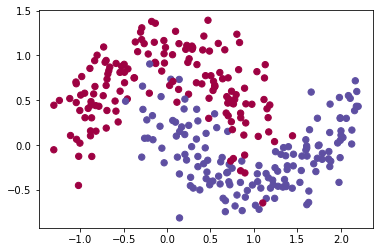

In [5]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_X, train_Y = load_dataset()

## 6 - The Model

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0,x)

In [7]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) *np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [8]:
def forward_propagation(X, parameters):
    """Implements the forward propagation."""
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [9]:
def compute_cost(a3, Y, minibatch=False):
    """
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    """
    if minibatch:
        m = 1
    else:
        m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

In [10]:
def backward_propagation(X, Y, cache):
    """Implement the backward propagation."""
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [11]:
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int64)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    return p

In [12]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, 
          beta1 = 0.9, 
          beta2 = 0.999, epsilon = 1e-8,          
          num_epochs = 5000, print_cost = True):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.

    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """        
    grads = {}
    costs = []         # to keep track of the cost
    m = X.shape[1]     # number of examples
    t = 0              # for adam
    seed = 10          # for minibatch shuffling
    layers_dims = [X.shape[0]] + layers_dims
    
    # Initialize parameters dictionary
    parameters = initialize_parameters(layers_dims)
    
    # Initialize the optimizer
    v, s = initialize_velocity_or_adam(parameters, optimizer)
    
    # Loop (gradient descent)
    for i in range(num_epochs):

        # Define random minibatches. Increment the seed to reshuffle differently after each epoch.
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, cache = forward_propagation(minibatch_X, parameters)       # Forward propagation
            cost_total += compute_cost(a3, minibatch_Y, True)              # Compute the cost
            grads = backward_propagation(minibatch_X, minibatch_Y, cache)  # backward propagation
            
            # Update parameters
            t += 1
            parameters, v, s, _, _ = update_parameters(parameters, grads, v, s, t, optimizer,
                                                       learning_rate, beta1, 
                                                       beta2, epsilon)

        cost_avg = cost_total/m
            
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after epoch {}: {:3f}".format(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (x100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [13]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

def predict_dec(parameters, X):
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

## 7 - Comparing Optimization Methods

In [14]:
# train 3-layer model
layers_dims = [5, 2, 1]

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


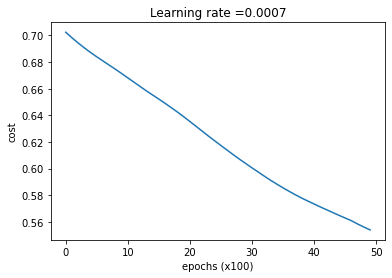

Accuracy: 0.7166666666666667


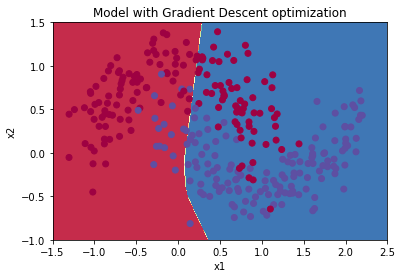

In [15]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


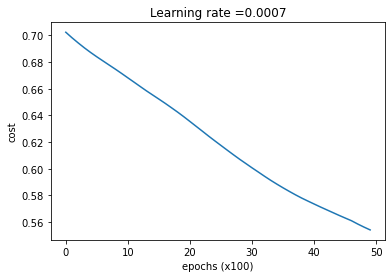

Accuracy: 0.7166666666666667


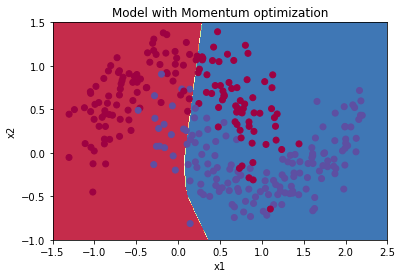

In [16]:
parameters = model(train_X, train_Y, layers_dims, beta1 = 0.9, optimizer = "momentum")

predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


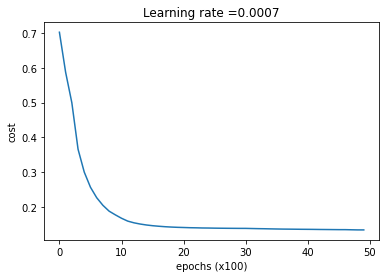

Accuracy: 0.9433333333333334


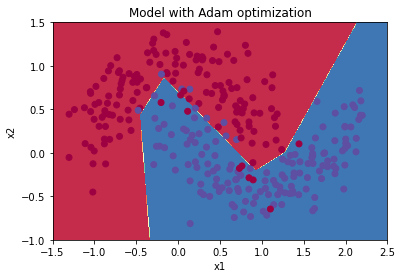

In [17]:
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)